In [1]:
import pyodbc
import pandas as pd

In [2]:
from sqlalchemy import create_engine
import urllib

In [3]:
import pyodbc
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)']


In [4]:
driver = 'ODBC Driver 17 for SQL Server'  
server = 'SHAHD'   
database = 'CustomerDataDB'


connection_string = f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

In [6]:
# URL encode the connection string
params = urllib.parse.quote_plus(connection_string)
# Create SQLAlchemy engine
engine = create_engine(f'mssql+pyodbc:///?odbc_connect={params}')

# DATA EXTRACTION
try:
    df_customers = pd.read_sql("SELECT * FROM Customer;", engine)
    print(df_customers.head())

    df_transactions = pd.read_sql("SELECT * FROM trnsaction;", engine)
    print(df_transactions.head())

    df_Interaction = pd.read_sql("SELECT * FROM Interaction;", engine)
    print(df_Interaction.head())

    
except Exception as e:
    print("An error occurred:", e)


   CustomerID FirstName LastName                       Email     Phone  \
0           1     ayaat    ahmed     ayaat.ahmed@example.com  555-1111   
1           2     shahd    ahmed     shahd.ahmed@example.com  555-2222   
2           3    maryam  mohamed  maryam.mohamed@example.com  555-3333   
3           4     renad  haytham   renad.haytham@example.com  555-4444   
4           5     salma   ashraf    salma.ashraf@example.com  555-5555   

         Address  
0     123 Elm St  
1     456 Oak St  
2    789 Pine St  
3  101 Maple Ave  
4   202 Birch Rd  
   TransactionID  CustomerID  InteractionID TransactionDate  Amount
0              2           1              1      2024-09-01   100.0
1              3           2              2      2024-09-02   250.0
2              4           3              3      2024-09-03   300.0
3              5           4              4      2024-09-04    50.0
4              6           5              5      2024-09-05    75.0
   InteractionID  CustomerID Inte

In [7]:
#PREPARE DATA FOR ANALYSIS
#Check for null values
print(df_customers.isnull().sum())
print(df_transactions.isnull().sum())
print( df_Interaction.isnull().sum())

CustomerID    0
FirstName     0
LastName      0
Email         0
Phone         0
Address       0
dtype: int64
TransactionID      0
CustomerID         0
InteractionID      0
TransactionDate    0
Amount             0
dtype: int64
InteractionID      0
CustomerID         0
InteractionType    0
Date               0
Notes              0
dtype: int64


In [8]:
print(df_customers)

     CustomerID FirstName LastName                       Email      Phone  \
0             1     ayaat    ahmed     ayaat.ahmed@example.com   555-1111   
1             2     shahd    ahmed     shahd.ahmed@example.com   555-2222   
2             3    maryam  mohamed  maryam.mohamed@example.com   555-3333   
3             4     renad  haytham   renad.haytham@example.com   555-4444   
4             5     salma   ashraf    salma.ashraf@example.com   555-5555   
..          ...       ...      ...                         ...        ...   
199         200      Ella    Brown      ella.brown@example.com   555-0171   
200         205     David    Smith     david.smith@example.com   555-5555   
201         207     Chris      Lee           chris.lee@invalid   555-7777   
202         209     James   Wilson    james.wilson@example.com   555-9999   
203         210      Lisa    Smith      lisa.smith@example.com   555-0000   

             Address  
0         123 Elm St  
1         456 Oak St  
2     

In [9]:
#remove duplicate values
df_customers.drop_duplicates(inplace=True)

<Axes: xlabel='Amount'>

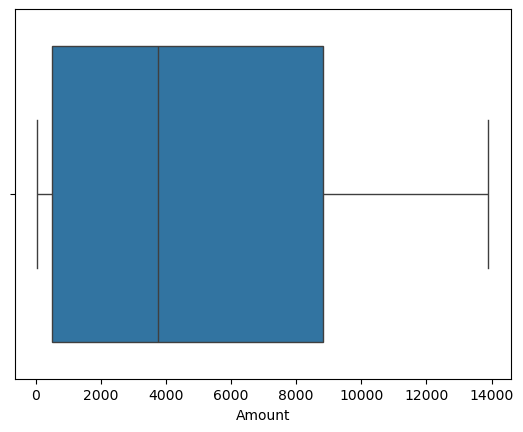

In [10]:
#Detect outliers using boxplots
import seaborn as sns
sns.boxplot(x=df_transactions['Amount'])

In [11]:
# Count the number of interactions per customer
customer_interactions = df_Interaction.groupby('CustomerID').size()
print(customer_interactions)

CustomerID
1      2
2      1
3      2
4      2
5      1
      ..
200    1
205    1
207    1
209    1
210    1
Length: 204, dtype: int64


In [12]:
# Ensure that the 'Date' column is in datetime format
df_Interaction['Date'] = pd.to_datetime(df_Interaction['Date'], errors='coerce')

# Check if there are any NaT (Not a Time) values after conversion
if df_Interaction['Date'].isnull().sum() > 0:
    print("Warning: Some dates could not be converted.")
    
# Extract month and year from date
df_Interaction['Month'] = df_Interaction['Date'].dt.to_period('M')
month_interactions = df_Interaction.groupby('Month').size()

print(month_interactions)

Month
2024-01    11
2024-02    29
2024-03    31
2024-04    30
2024-05    31
2024-06    30
2024-07    23
2024-08     2
2024-09    21
Freq: M, dtype: int64


In [13]:
# count the number of interactions of each type.
interaction_counts = df_Interaction.groupby('InteractionType').size()
print(interaction_counts)

InteractionType
 Email         62
 Meeting       61
 Phone Call    62
Email           8
Meeting         7
Phone Call      8
dtype: int64


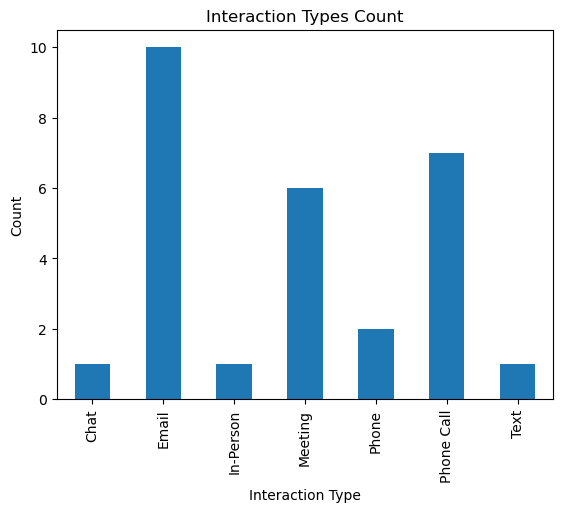

In [27]:
import matplotlib.pyplot as plt
interaction_counts.plot(kind='bar')
plt.title('Interaction Types Count')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.show()


In [14]:
# PREDICTIVE MODEL
#merge tables
df_combined = pd.merge(df_customers, df_Interaction, on='CustomerID', how='left')
df_combined = pd.merge(df_combined, df_transactions, on='CustomerID', how='left')
print(df_combined)

     CustomerID FirstName LastName                      Email      Phone  \
0             1     ayaat    ahmed    ayaat.ahmed@example.com   555-1111   
1             1     ayaat    ahmed    ayaat.ahmed@example.com   555-1111   
2             1     ayaat    ahmed    ayaat.ahmed@example.com   555-1111   
3             1     ayaat    ahmed    ayaat.ahmed@example.com   555-1111   
4             1     ayaat    ahmed    ayaat.ahmed@example.com   555-1111   
..          ...       ...      ...                        ...        ...   
310         200      Ella    Brown     ella.brown@example.com   555-0171   
311         205     David    Smith    david.smith@example.com   555-5555   
312         207     Chris      Lee          chris.lee@invalid   555-7777   
313         209     James   Wilson   james.wilson@example.com   555-9999   
314         210      Lisa    Smith     lisa.smith@example.com   555-0000   

             Address  InteractionID_x InteractionType       Date  \
0         123 Elm S

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


df_combined['Total_Interactions'] = df_combined.groupby('CustomerID')['InteractionID_x'].transform('count')
df_combined['Total_Transactions'] = df_combined.groupby('CustomerID')['TransactionID'].transform('count')
df_combined['Total_Amount_Spent'] = df_combined.groupby('CustomerID')['Amount'].transform('sum')
df_combined['Last_Transaction_Date'] = df_combined.groupby('CustomerID')['TransactionDate'].transform('max')
df_combined['Days_Since_Last_Transaction'] = (pd.Timestamp('2024-10-21') - df_combined['Last_Transaction_Date']).dt.days

# Label Creation: Assume churned if no transaction in last 30 days
df_combined['Churn'] = df_combined['Days_Since_Last_Transaction'].apply(lambda x: 1 if x > 30 else 0)
# Remove duplicates by CustomerID to have one row per customer
df_clean = df_combined.drop_duplicates(subset='CustomerID')

# Features and Target
X = df_clean[['Total_Interactions', 'Total_Transactions', 'Total_Amount_Spent', 'Days_Since_Last_Transaction']]
y = df_clean['Churn']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions for the test set
y_pred = model.predict(X_test)

# Output the results
results = pd.DataFrame({
    'CustomerID': df_clean.loc[X_test.index, 'CustomerID'],
    'Total_Interactions': df_clean.loc[X_test.index, 'Total_Interactions'],
    'Total_Amount_Spent': df_clean.loc[X_test.index, 'Total_Amount_Spent'],
    'Predicted_Churn': y_pred
})


print(results)

     CustomerID  Total_Interactions  Total_Amount_Spent  Predicted_Churn
40           16                   2               990.0                0
29           10                   2               950.0                0
226         116                   1                 0.0                0
167          79                   2             19300.0                1
143          67                   2             14500.0                1
101          46                   2              6100.0                1
243         133                   1                 0.0                0
272         162                   1                 0.0                0
312         207                   1               300.0                1
292         182                   1                 0.0                0
149          70                   2             15700.0                1
274         164                   1                 0.0                0
278         168                   1                